## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd

# pytorch functions
import torch
import torchaudio
import torchvision
import torchvision.utils
import torchvision.transforms as transforms
import torch.utils.data as data
from torchsummary import summary
from torchvision import datasets
import random
from torch.utils.data import Dataset

# libraries for neural networks
import torch.nn as nn
import torch.nn.functional as functional

# libraries for visualisation of images
from torchvision.utils import make_grid
import time

# libraries for plotting accuracy loss curves
import pylab as pl
import matplotlib.pyplot as plt
import os
from matplotlib.markers import MarkerStyle

# libraries for optimizers
import torch.optim as optim
import copy

## Selecting the right device
Pytorch codes run impressively fast on GPU devices. So we set the device to GPU if it is available, else we run on the cuda device.

In [2]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    # Set the device to the first available GPU
    device = torch.device("cuda")
else:
    # If CUDA is not available, set the device to CPU
    device = torch.device("cpu")

print("Using device:", device)

Using device: cuda


### Generating Base inherited class from nn.Module of pytorch

In [3]:
class BaseNeural(nn.Module):

    def select_loss_fn(self, learn_rate, opt_function, moment = None):
        default_criterion = nn.CrossEntropyLoss()
        # if the chosen optimizer is SGD, creating an SGD optimizer with provided learning rate and optimizer
        if opt_function == "SGD":
            optimizer = optim.SGD(self.parameters(), lr=learn_rate, momentum=moment)
        # if the optimizer is Adam, creating an adam optimizer with given learning rate, adam doesn't need momentum
        elif opt_function =="Adam":
            optimizer = optim.Adam(self.parameters(), lr = learn_rate)
        # # if any optimizer other than these is used, then value error will be raised
        else:
            raise ValueError("Unsupported optimizer!")

        return default_criterion, optimizer


    # defining a function to show image, same as done in one of the workshop codes
    def imshow(self, img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()


    # defining a method/function to be used later on for calculating loss and accuracy of each epoch
    def calculate_accuracy_and_loss(self, dataloader, flag='train'):
        # Setting the model to evaluation mode
        self.eval()

        # Initialize lists to store losses and accuracy values
        loss_list = []
        accuracy_list = []

        # Initialize mean_loss and accuracy
        mean_loss, accuracy = 0, 0
        response_size = 0

        # Get the loss function and optimizer
        default_criterion = self.default_criterion
        optimizer = self.optimizer

        # Gradient is not required as we are not training
        with torch.no_grad():
            for i, data in enumerate(dataloader, 0):
                # Getting the features(predictors) and responses(labels)
                features, responses = data[0].to(device), data[1].to(device)

                # Forward passing the features to predict
                outputs = self.forward(features)

                # Calculating the accuracy
                response_size += responses.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct_predictions = (predicted == responses).sum().item()
                accuracy_list.append(correct_predictions)

                # Calculating the loss
                loss = default_criterion(outputs, responses)
                loss_list.append(loss.item())

        # Calculating the mean loss and accuracy
        mean_loss = np.mean(loss_list)
        accuracy = (100 * np.sum(accuracy_list) / response_size)

        return accuracy, mean_loss

    def calculate_accuracy(self, flag):
        # Choosing the appropriate data loader based on the flag
        if flag == 'val':
            dataloader = self.valloader
        else:
            dataloader = self.testloader

        # setting the model to evaluation mode
        self.eval()

        # Initializing variables to count correct and total predictions
        correct_predictions = 0
        total_predictions = 0

        # Gradient is not required as we are not training
        with torch.no_grad():
            for data in dataloader:
                features, responses = data[0].to(device), data[1].to(device)
                outputs = self(features)
                _, predicted = torch.max(outputs.data, 1)
                total_predictions += responses.size(0)
                correct_predictions += (predicted == responses).sum().item()

        # Calculating and printing the accuracy
        accuracy = (correct_predictions / total_predictions)*100
        print(f'Network accuracy on the {len(dataloader)} images: {round(accuracy,3)}%')

        return accuracy

    # a method to calculate each class's individual accuracy
    def calculate_class_accuracy(self, flag='val'):
        # Choosing the appropriate data loader based on the flag
        if flag == 'val':
            dataloader = self.valloader
        else:
            dataloader = self.testloader

        # Setting the model to evaluation mode
        self.eval()

        # Initializing lists to store correct predictions for each class and total predictions for each class
        class_correct = [0] * 10
        class_total = [0] * 10

        # Gradient is not required as we are not training
        with torch.no_grad():
            for data in dataloader:
                features, responses = data[0].to(device), data[1].to(device)
                outputs = self(features)
                _, predicted = torch.max(outputs, 1)
                correct = (predicted == responses).squeeze()

                for i in range(4):
                    response = responses[i]
                    class_correct[response] += correct[i].item()
                    class_total[response] += 1

        for i in range(0, 10):
            accuracy = (class_correct[i] / class_total[i])*100
            print(f'Accuracy of {self.classes[i]:5s} : {round(accuracy,3)}%')

    # defining a helper function to un-normalize and display an image
    def show_image(self, loader):
        img, label = loader
        print('Label: ', self.classes[label], "(" + str(label) + ")")
        plt.imshow(img.permute(1, 2, 0))


    def model_train_fn(self, num_epochs, learn_rate=0.1, opt_function="SGD", moment=0.4):
        # intialising a list to keep an account of the stats of the present model
        training_summary = []

        # Set the loss function and optimizer
        self.default_criterion, self.optimizer = self.select_loss_fn(learn_rate, opt_function, moment)

        default_criterion = self.default_criterion
        optimizer = self.optimizer
        self.num_epochs = num_epochs
        self.summary = []
        early_stopper = EarlyStopper(patience=5, least_del=0.0)
        # intialising a time variable to take into account the time for the model to run
        intial_time = time.time()

        for epoch in range(0,num_epochs):
            self.train()
            intial_loss = 0.0
            # intilising a list to store training loss for each training run
            loss_training = []
            # initalising a list to store training accuracy for each training run
            accuracy_training = []

            for i, data in enumerate(self.trainloader, 0):
                # using a similar chunk of code from the workshops
                # data comprises of features(input variables) and response(output variable)
                features, responses = data[0].to(device), data[1].to(device)

                # using intial parameters gradients as zero
                optimizer.zero_grad()
                outputs = self.forward(features)
                loss = default_criterion(outputs, responses)
                loss.backward()
                optimizer.step()

                # appending loss to the list created earlier
                # loss_training.append(loss.item())

            # next, calculating training accuracy and loss
            accuracy_training, loss_training = self.calculate_accuracy_and_loss(self.trainloader)

            # calculating validation accuracy and loss
            accuracy_validation, loss_validation = self.calculate_accuracy_and_loss(self.valloader, "val")

            if early_stopper.early_stop(loss_validation):
                print("Early Stopping triggered")
                break

            # storing the accuracy and loss values for the present epoch(training run) in a dictionary
            summary_train_present_epoch = {
                "epoch": epoch + 1,
                "Training_Loss": loss_training,
                "Training_Accuracy": accuracy_training,
                "Validation_Accuracy": accuracy_validation,
                "Validation_Loss": loss_validation
            }

            # printing the above dictionary
            print(summary_train_present_epoch)
            self.summary.append(summary_train_present_epoch)

        # self.summary = training_summary
        #$print(self.summary)
        # print(training_summary)
        print('Training ended for this run!')
        execution_time = round((time.time() - intial_time) / 60, 2)
        print(f"Execution time: {execution_time} minutes")


    # plotting the graph for the loss-acccuracy curve as epochs change
    def plot_loss_accuracy_graph(self):
        accuracies_train = [x['Training_Accuracy'] for x in self.summary]
        accuracies_validation = [x['Validation_Accuracy'] for x in self.summary]
        losses_train = [x['Training_Loss'] for x in self.summary]
        losses_validation = [x['Validation_Loss'] for x in self.summary]

        # generating the loss curve
        plt.figure(figsize=(8, 6))
        plt.title("Training/Validation Loss vs Epochs")
        plt.plot(range(self.num_epochs), losses_validation, label="Validation Loss")
        plt.plot(range(self.num_epochs), losses_train, label="Training Loss")
        plt.legend()
        plt.show()

        # generating the accuracy curve
        plt.figure(figsize=(8, 6))
        plt.title("Training/Validation Accuracy vs Epochs")
        plt.plot(range(self.num_epochs), accuracies_validation, label="Validation Accuracy")
        plt.plot(range(self.num_epochs), accuracies_train, label="Training Accuracy")
        plt.legend()
        plt.show()

    # defining the method for live plot updates with optional last_plot handling
    def plot_graph(self, x, last_plot=False):
        accuracies_train = [x['Training_Accuracy'] for x in self.summary]
        accuracies_validation = [x['Validation_Accuracy'] for x in self.summary]
        losses_train = [x['Training_Loss'] for x in self.summary]
        losses_validation = [x['Validation_Loss'] for x in self.summary]

        x_range = range(x)

        plt.close()
        plt.figure(figsize=(8, 6))
        markersize = 4

        # next, plotting the data
        plt.plot(x_range, accuracies_train, color='red', linestyle='--', marker='x', markersize=markersize)
        plt.plot(x_range, accuracies_validation, color='blue', linestyle='--', marker='x', markersize=markersize)
        plt.plot(x_range, losses_train, color='green', linestyle='--', marker='x', markersize=markersize)
        plt.plot(x_range, losses_validation, color='yellow', linestyle='--', marker='x', markersize=markersize)

        # further, customizing the plot
        plt.grid(color='black', linestyle='--', linewidth=0.5)
        plt.legend(['Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss'])
        plt.xlabel('Epochs')
        plt.title('Visual interpretation of the summary')

        # Display the plot
        plt.show()



class EarlyStopper:
    def __init__(self, patience = 1, least_del=0.0):
        """
        Initializing the EarlyStopper class to stop the training at the appropriate level to avaoid overfitting and underfitting

        Args:
        - patience (int): Number of epochs with no improvement after which training will be stopped.
        - least_del(float): Minimum change in the monitored quantity to be considered as improvement.

        """
        self.patience = patience
        self.least_del = least_del
        self.wait = 0
        self.best_val_loss = float('inf')  # Initializing with positive infinity
        self.stopped_epoch = 0

    def early_stop(self, current_val_loss):
        """
        Checking if the early stopping criteria are met.

        Args:
        - current_val_loss (float): Current validation loss.

        Returns:
        - (bool): True if early stopping criteria are met, False otherwise.

        """
        if current_val_loss is None:
            return False

        if current_val_loss + self.least_del < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = self.wait
                return True  # Stop training
        return False

    def stopped_epoch(self):
        """
        Getting the epoch at which training was stopped due to early stopping.

        Returns:
        - (int): Epoch at which training was stopped.

        """
        return self.stopped_epoch



### Showing some images from the dataset

100%|██████████| 170498071/170498071 [00:04<00:00, 38536873.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


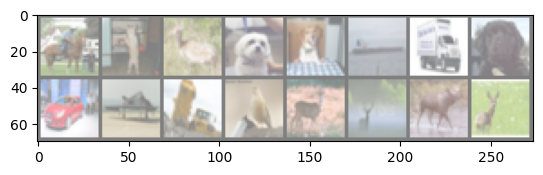

horse cat   deer  dog   dog   ship  truck dog   car   plane truck bird  deer  deer  deer  deer 


In [4]:
# defining a function to show image, same as done in one of the workshop codes
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Loading the CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Creating a data loader
batch_size = 16   # to specify the number fo images displayed
data_loader = torch.utils.data.DataLoader(cifar_dataset, batch_size=batch_size, shuffle=True)

# Defining class labels for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Getting some random training images
dataiter = iter(data_loader)
images, labels = next(dataiter)

# Showing images and labels
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


### Experiment 1: Creating the basic CNN structure for the first model

In [5]:
# creating a new inherited class from the basic neural class defined above
class Basic_CNN(BaseNeural):
    def __init__(self, dataset="CIFAR10", batch_size=32, data_path='./data', validation_split=0.2):
        super().__init__()
        torch.manual_seed(42)    # using seed for reproducibility
        # attribute to control shapes logging feature for better flexibility
        self.enable_shapes_logging = False

        # defining CNN Layer 1
        # the three arguments in the Conv2d function are in_channels, out_channels and kernel_size
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)

        # defining CNN Layer 2
        self.conv2 = nn.Conv2d(6, 16, 5)

        # defining fully connected layer 1
        self.fc1 = nn.Linear(16 * 5 * 5, 120)

        # defining fully connected layer 2
        self.fc2 = nn.Linear(120, 84)

        # defining fully connected layer 3
        self.fc3 = nn.Linear(84, 10)

        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        # initilizing a few variables to store results
        self.default_criterioncriterion = None
        self.optimizer = None

        # intializing a summary list to store the results
        self.summary = []
        # intializing number of epochs to zero
        self.epoch = 0


        # making a train, validation, test split on the dataset
        '''
        Since the datset I am working here with is the CIFAR 10 dataset,
        so making the splits only if the passed dataset is the CIFAR 10 dataset.
        '''
        if dataset == "CIFAR10":
            # using in-built torch functions to load the dataset
            dataset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)

            # using 20 percent of the data as the validation set
            validation_size = int(len(dataset) * validation_split)

            # eveything except validation will be used to train the dataset
            training_size = len(dataset) - validation_size
            training_set, validation_set = data.random_split(dataset, [training_size, validation_size])
            self.train_set = training_set
            self.trainloader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=2)
            print("Training Size:", len(training_set))

            self.valloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=2)
            print("Validation Size:", len(validation_set))

            testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
            print("Testing Size:", len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # defining the forward pass method
    def forward(self, x):
        if self.enable_shapes_logging:
            print("Initial x shape", x.shape)

        # defining first CNN layer
        x = self.conv1(x)
        x = functional.relu(x)
        x = self.pool(x)

        # defining second layer for CNN
        x = self.conv2(x)
        x = functional.relu(x)
        x = self.pool(x)

        # post this, all dimensions excpet batch will be flatteened
        x = torch.flatten(x, 1)

        # adding a fully connected first layer
        x = self.fc1(x)
        x = functional.relu(x)

        # adding a fullt connected second layer
        x = self.fc2(x)
        x = functional.relu(x)

        # finally adding the last linear layer
        x = self.fc3(x)
        return x

# Create an instance of Bsic_CNN model
model = Basic_CNN().to(device)
summary(model, (3, 32, 32))


Files already downloaded and verified
Training Size: 40000
Validation Size: 10000
Files already downloaded and verified
Testing Size: 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
---------------------------------

#### Creating the first model object from the above defined inherited class

Files already downloaded and verified
Training Size: 40000
Validation Size: 10000
Files already downloaded and verified
Testing Size: 10000
{'epoch': 1, 'Training_Loss': 1.447300769853592, 'Training_Accuracy': 47.2775, 'Validation_Accuracy': 46.1, 'Validation_Loss': 1.4784205464509348}
{'epoch': 2, 'Training_Loss': 1.2736308553695679, 'Training_Accuracy': 54.4175, 'Validation_Accuracy': 52.54, 'Validation_Loss': 1.3314318441735289}
{'epoch': 3, 'Training_Loss': 1.0903989525794984, 'Training_Accuracy': 60.9825, 'Validation_Accuracy': 56.85, 'Validation_Loss': 1.2056022335926946}
{'epoch': 4, 'Training_Loss': 1.0210319135665893, 'Training_Accuracy': 64.0525, 'Validation_Accuracy': 58.53, 'Validation_Loss': 1.1809813982000748}
{'epoch': 5, 'Training_Loss': 0.9643549845695496, 'Training_Accuracy': 65.8375, 'Validation_Accuracy': 58.48, 'Validation_Loss': 1.1726059073838182}
Training ended for this run!
Execution time: 4.16 minutes


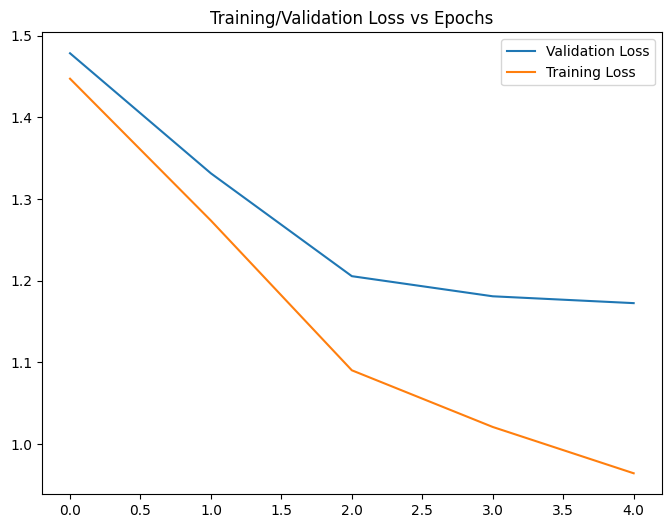

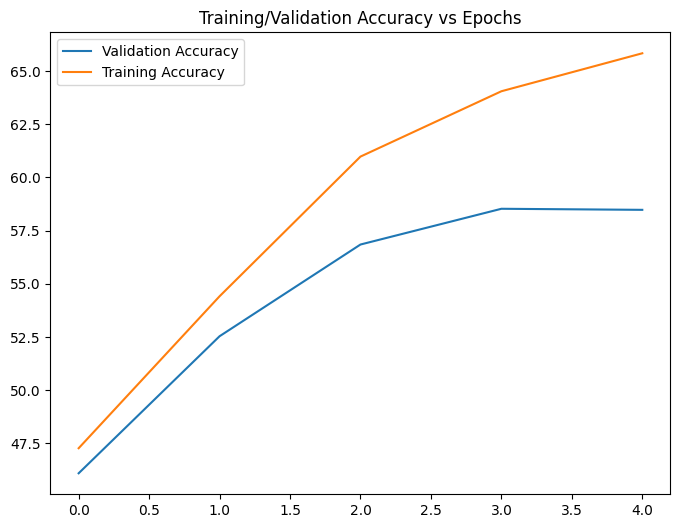

In [ ]:
# creating an instance of the Basic_CNN object
first_exp_model = Basic_CNN()

# moving the model to the default device
first_exp_model = first_exp_model.to(device)

# Train the model with specified hyperparameters
first_exp_model.model_train_fn(num_epochs=5, learn_rate=0.01, opt_function="SGD", moment=0.9)

# Show the training and validation loss/accuracy graph
first_exp_model.plot_loss_accuracy_graph()


In [ ]:
first_exp_model.calculate_class_accuracy("val")

Accuracy of plane : 57.018%
Accuracy of car   : 68.382%
Accuracy of bird  : 50.746%
Accuracy of cat   : 36.585%
Accuracy of deer  : 56.667%
Accuracy of dog   : 53.279%
Accuracy of frog  : 66.667%
Accuracy of horse : 46.875%
Accuracy of ship  : 79.286%
Accuracy of truck : 81.818%


### Experiment 2: Hyperparameter tuning to improve performance

In [ ]:
# intializing the list to have the final results
hp_results = []

# parameters to be tuned are put in separate lists
opt = ["SGD", "Adam"]
learn_r = [0.001, 0.0001, 0.01, 0.1, 1]

# making another instance from the basic model to tune the hyperparameters(optimizer and learning rate here)
hp_tune_first_model = Basic_CNN()

# assigning the instance to the device
hp_tune_first_model = hp_tune_first_model.to(device)

# creating multiple for loops for displaying results for different combinations
for o in opt:
    for l in learn_r:
        print(f"For the combination of optimizer {o} and learning rate {l}")
        hp_tune_first_model.model_train_fn(3, l, o)

        val_accuracy , val_loss = hp_tune_first_model.calculate_accuracy_and_loss(hp_tune_first_model.valloader, "val")

        hp_results.append({"Optimizer" : o,
                          "Learning Rate" : l,
                          "Validation Accuracy": val_accuracy,
                          "Validation Loss" : val_loss})

        # print(f"Training finished for this combination of hyperparameters involving optimizer {o} and learning rate {l}")
# ingreate a DataFrame from the results list
df = pd.DataFrame(hp_results)

# sorting the DataFrame by Validation Accuracy in descending order
df = df.sort_values(by='Validation Accuracy', ascending=False)

# Display the sorted DataFrame
print(df)

Files already downloaded and verified
Training Size: 40000
Validation Size: 10000
Files already downloaded and verified
Testing Size: 10000
For the combination of optimizer SGD and learning rate 0.001
{'epoch': 1, 'Training_Loss': 2.3019538539886475, 'Training_Accuracy': 12.4875, 'Validation_Accuracy': 12.85, 'Validation_Loss': 2.301788595156929}
{'epoch': 2, 'Training_Loss': 2.2975356977462766, 'Training_Accuracy': 15.57, 'Validation_Accuracy': 15.68, 'Validation_Loss': 2.2975124139755296}
{'epoch': 3, 'Training_Loss': 2.287166152191162, 'Training_Accuracy': 16.585, 'Validation_Accuracy': 16.97, 'Validation_Loss': 2.287200793671532}
Training ended for this run!
Execution time: 2.5 minutes
For the combination of optimizer SGD and learning rate 0.0001
{'epoch': 1, 'Training_Loss': 2.2853041927337645, 'Training_Accuracy': 16.74, 'Validation_Accuracy': 16.92, 'Validation_Loss': 2.2852883971156404}
{'epoch': 2, 'Training_Loss': 2.2831609422683714, 'Training_Accuracy': 16.7375, 'Validation_

In [ ]:
print(df.head(1))

  Optimizer  Learning Rate  Validation Accuracy  Validation Loss
3       SGD            0.1                57.23          1.22255


Making model from the best hyperparameters and testing it on the test set

Files already downloaded and verified
Training Size: 40000
Validation Size: 10000
Files already downloaded and verified
Testing Size: 10000
{'epoch': 1, 'Training_Loss': 2.0565630910873414, 'Training_Accuracy': 21.94, 'Validation_Accuracy': 21.61, 'Validation_Loss': 2.071438588654271}
{'epoch': 2, 'Training_Loss': 2.3242361392974855, 'Training_Accuracy': 10.75, 'Validation_Accuracy': 10.44, 'Validation_Loss': 2.3361494868708115}
{'epoch': 3, 'Training_Loss': 2.0589575602531434, 'Training_Accuracy': 20.0525, 'Validation_Accuracy': 19.28, 'Validation_Loss': 2.069949545037632}
{'epoch': 4, 'Training_Loss': 1.995286559009552, 'Training_Accuracy': 23.0, 'Validation_Accuracy': 22.84, 'Validation_Loss': 2.000472266453143}
{'epoch': 5, 'Training_Loss': 2.023671100616455, 'Training_Accuracy': 20.815, 'Validation_Accuracy': 20.03, 'Validation_Loss': 2.032013065898761}
Training ended for this run!
Execution time: 4.15 minutes


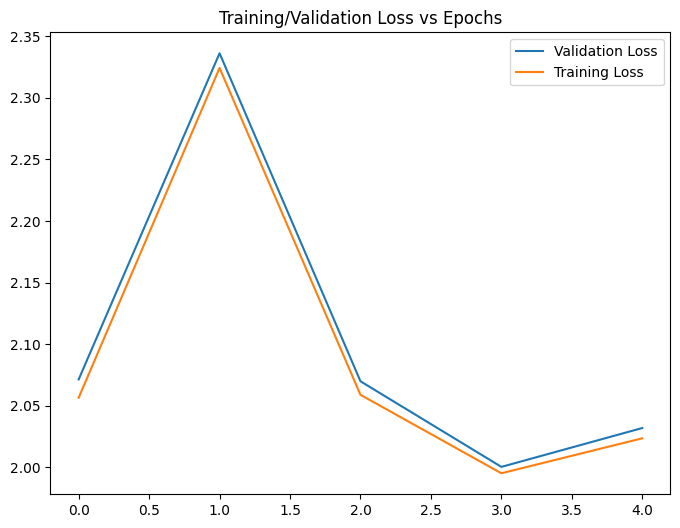

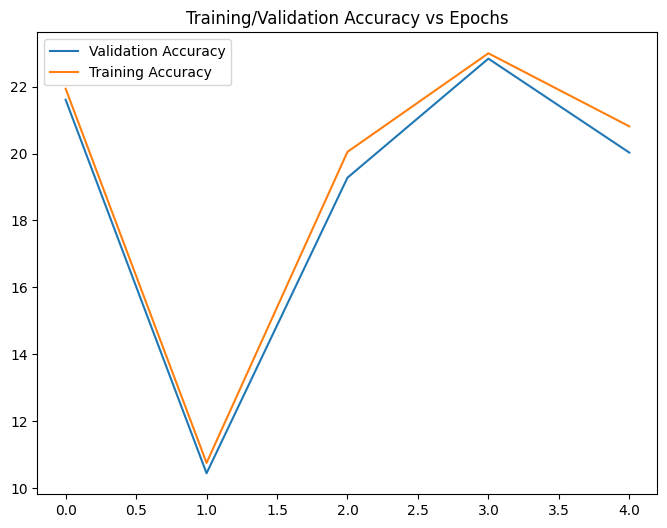

The accuracy on the test set for the first model is:  20.56
The loss on the test set for the first model is  2.0225027635836375
Accuracy of plane : 69.027%
Accuracy of car   : 39.13%
Accuracy of bird  : 2.632%
Accuracy of cat   : 0.0%
Accuracy of deer  : 48.485%
Accuracy of dog   : 43.363%
Accuracy of frog  : 0.0%
Accuracy of horse : 0.0%
Accuracy of ship  : 0.0%
Accuracy of truck : 2.941%


In [ ]:
# making the final model with best hyperparameters
final_model1 = Basic_CNN()

# moving the model to the default device
final_model1 = final_model1.to(device)

# Train the model with specified hyperparameters
final_model1.model_train_fn(num_epochs=5, learn_rate=0.1, opt_function="SGD", moment=0.9)

# Show the training and validation loss/accuracy graph
final_model1.plot_loss_accuracy_graph()

test_accuracy, test_loss = final_model1.calculate_accuracy_and_loss(final_model1.testloader, flag = 'test')

print("The accuracy on the test set for the first model is: ", test_accuracy)
print("The loss on the test set for the first model is ", test_loss)

final_model1.calculate_class_accuracy("test")

### Experiment 3: Creating Basic_CNN2 with Data Augmentation

In [ ]:
# creating a custom Dataset to apply transformations for data augmentation
# class TransformedSubset(Dataset):
#                 def __init__(self, subset, transform=None):
#                     self.subset = subset
#                     self.transform = transform

#                 def __getitem__(self, index):
#                     x, y = self.subset[index]
#                     if self.transform:
#                         x = self.transform(x)
#                     return x, y

#                 def __len__(self):
#                     return len(self.subset)

# creating a new inherited class from the basic neural class defined above
class Basic_CNN2(BaseNeural):
    def __init__(self, dataset="CIFAR10", batch_size=32, data_path='./data', validation_split=0.2):
        super().__init__()
        torch.manual_seed(42)    # using seed for reproducibility
        # attribute to control shapes logging feature for better flexibility
        self.enable_shapes_logging = False

        # defining CNN Layer 1
        # the three arguments in the Conv2d function are in_channels, out_channels and kernel_size
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)

        # defining CNN Layer 2
        self.conv2 = nn.Conv2d(6, 16, 5)

        # defining fully connected layer 1
        self.fc1 = nn.Linear(16 * 5 * 5, 120)

        # defining fully connected layer 2
        self.fc2 = nn.Linear(120, 84)

        # defining fully connected layer 3
        self.fc3 = nn.Linear(84, 10)

        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        ### CODE ALTERED
        # New transform with data augmentation
        transform_train = transforms.Compose([
        transforms.RandomResizedCrop(32),  # Random crop
        transforms.RandomHorizontalFlip(),  # 50% chance of horizontal flip
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])

        # initilizing a few variables to store results
        self.default_criterioncriterion = None
        self.optimizer = None

        # intializing a summary list to store the results
        self.summary = []
        # intializing number of epochs to zero
        self.epoch = 0


        # making a train, validation, test split on the dataset
        '''
        Since the datset I am working here with is the CIFAR 10 dataset,
        so making the splits only if the passed dataset is the CIFAR 10 dataset.
        '''
        if dataset == "CIFAR10":
            # using in-built torch functions to load the dataset
            dataset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform_train)

            # using 20 percent of the data as the validation set
            validation_size = int(len(dataset) * validation_split)

            # eveything except validation will be used to train the dataset
            training_size = len(dataset) - validation_size
            training_set, validation_set = torch.utils.data.random_split(dataset, [training_size, validation_size])

            # applying specific transforms to each part of the dataset
            #training_set = torch.utils.data.Subset(training_set, range(training_size))

            # # Creating a transformed subset of the training set
            # transformed_training_set = TransformedSubset(training_set, transform=transform_train)

            # validation_set = torch.utils.data.Subset(validation_set, range(validation_size))
            # # Similarly for the validation set
            # transformed_validation_set = TransformedSubset(validation_set, transform=transform)

            # For training set
            #full_train_dataset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform_train)

            # # Create a train/validation split
            # train_size = int(0.8 * len(full_train_dataset))
            # val_size = len(full_train_dataset) - train_size

            # train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

            # Apply different transform to validation set
            val_dataset = copy.deepcopy(validation_set)
            val_dataset.dataset.transform = transform

            # For test set (using original transform)
            testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

            self.train_set = training_set
            self.trainloader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=2)
            print("Training Size:", len(training_set))

            self.valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
            print("Validation Size:", len(val_dataset))

            testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
            print("Testing Size:", len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # defining the forward pass method
    def forward(self, x):
        if self.enable_shapes_logging:
            print("Initial x shape", x.shape)

        # defining first CNN layer
        x = self.conv1(x)
        x = functional.relu(x)
        x = self.pool(x)

        # defining second layer for CNN
        x = self.conv2(x)
        x = functional.relu(x)
        x = self.pool(x)

        # post this, all dimensions excpet batch will be flatteened
        x = torch.flatten(x, 1)

        # adding a fully connected first layer
        x = self.fc1(x)
        x = functional.relu(x)

        # adding a fullt connected second layer
        x = self.fc2(x)
        x = functional.relu(x)

        # finally adding the last linear layer
        x = self.fc3(x)
        return x

# Create an instance of Basic_CNN2
model = Basic_CNN2().to(device)
summary(model, (3, 32, 32))


Files already downloaded and verified
Files already downloaded and verified
Training Size: 40000
Validation Size: 10000
Files already downloaded and verified
Testing Size: 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 

### Creating the second model instance to check its performance

Files already downloaded and verified
Files already downloaded and verified
Training Size: 40000
Validation Size: 10000
Files already downloaded and verified
Testing Size: 10000
{'epoch': 1, 'Training_Loss': 1.8646220158576965, 'Training_Accuracy': 31.14, 'Validation_Accuracy': 36.99, 'Validation_Loss': 1.7134427441575657}
{'epoch': 2, 'Training_Loss': 1.742347179698944, 'Training_Accuracy': 36.2075, 'Validation_Accuracy': 43.69, 'Validation_Loss': 1.5502842200069}
{'epoch': 3, 'Training_Loss': 1.6788333577156067, 'Training_Accuracy': 38.57, 'Validation_Accuracy': 46.71, 'Validation_Loss': 1.4726452240928674}
{'epoch': 4, 'Training_Loss': 1.651720716381073, 'Training_Accuracy': 39.7575, 'Validation_Accuracy': 49.12, 'Validation_Loss': 1.4070223804099111}
{'epoch': 5, 'Training_Loss': 1.6324913579940796, 'Training_Accuracy': 41.2525, 'Validation_Accuracy': 49.42, 'Validation_Loss': 1.4488467985448745}
Training ended for this run!
Execution time: 4.15 minutes


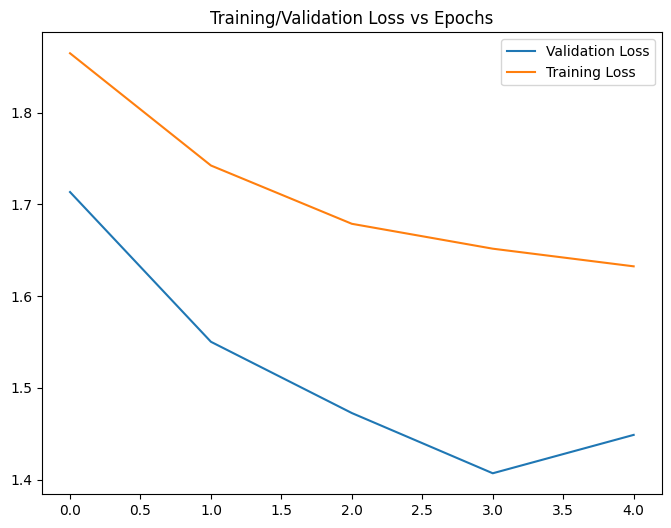

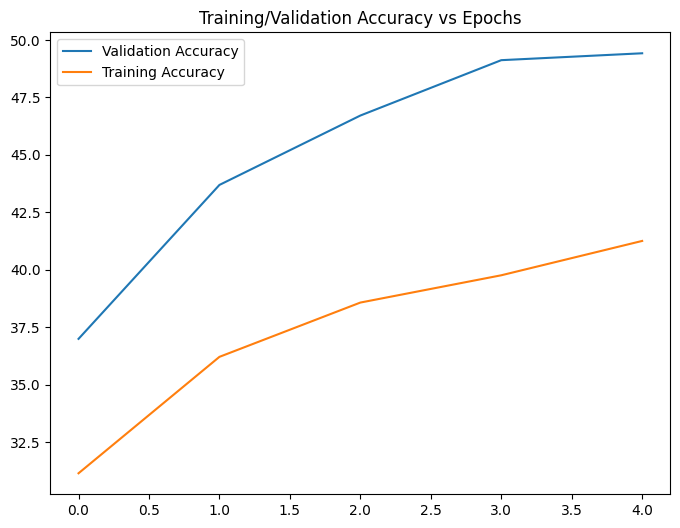

In [ ]:
# creating an instance
second_exp_model = Basic_CNN2()

# moving the model to the default device
second_exp_model = second_exp_model.to(device)

# Train the model with specified hyperparameters
second_exp_model.model_train_fn(num_epochs=5, learn_rate=0.01, opt_function="SGD", moment=0.9)

# Show the training and validation loss/accuracy graph
second_exp_model.plot_loss_accuracy_graph()

In [ ]:
second_exp_model.calculate_class_accuracy("val")

Accuracy of plane : 47.414%
Accuracy of car   : 74.576%
Accuracy of bird  : 27.737%
Accuracy of cat   : 7.317%
Accuracy of deer  : 40.476%
Accuracy of dog   : 38.532%
Accuracy of frog  : 76.154%
Accuracy of horse : 62.676%
Accuracy of ship  : 68.75%
Accuracy of truck : 50.407%


### Experiment 4: Creating model 3 with Batch Normalization, relu activation and dropout layer

In [ ]:
class Basic_CNN3(BaseNeural):
    def __init__(self, dataset="CIFAR10", batch_size=32, data_path='./data', validation_split=0.2):
        super().__init__()
        torch.manual_seed(42)    # using seed for reproducibility

        # adding first Convolutional Layer
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        # adding second Convolutional Layer
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        # adding third Convolutional Layer
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)

        # adding a dropout Layer
        self.dropout1 = nn.Dropout(0.5)

        # adding fully connected layers
        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.act4 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        # initilizing a few variables to store results
        self.default_criterioncriterion = None
        self.optimizer = None

        # intializing a summary list to store the results
        self.summary = []
        # intializing number of epochs to zero
        self.epoch = 0


        # making a train, validation, test split on the dataset
        '''
        Since the datset I am working here with is the CIFAR 10 dataset,
        so making the splits only if the passed dataset is the CIFAR 10 dataset.
        '''
        if dataset == "CIFAR10":
            # using in-built torch functions to load the dataset
            dataset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)

            # using 20 percent of the data as the validation set
            validation_size = int(len(dataset) * validation_split)

            # eveything except validation will be used to train the dataset
            training_size = len(dataset) - validation_size
            training_set, validation_set = data.random_split(dataset, [training_size, validation_size])
            self.train_set = training_set
            self.trainloader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=2)
            print("Training Size:", len(training_set))

            self.valloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=2)
            print("Validation Size:", len(validation_set))

            testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
            print("Testing Size:", len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.pool3(x)

        x = self.dropout1(x)

        x = x.view(-1, 128 * 2 * 2)

        x = self.fc1(x)
        x = self.act4(x)

        x = self.fc2(x)
        return x

# Create an instance of Bsic_CNN3 model
model = Basic_CNN3().to(device)
summary(model, (3, 32, 32))


Files already downloaded and verified
Training Size: 40000
Validation Size: 10000
Files already downloaded and verified
Testing Size: 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
         MaxPool2d-4           [-1, 32, 15, 15]               0
            Conv2d-5           [-1, 64, 13, 13]          18,496
       BatchNorm2d-6           [-1, 64, 13, 13]             128
              ReLU-7           [-1, 64, 13, 13]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Conv2d-9            [-1, 128, 4, 4]          73,856
      BatchNorm2d-10            [-1, 128, 4, 4]             256
             ReLU-11            [-1, 128, 4, 4]               0
        MaxPool2d-12       

### Creating an instance from the Basic_CNN3 model class to test how effect the model of that class is

Files already downloaded and verified
Training Size: 40000
Validation Size: 10000
Files already downloaded and verified
Testing Size: 10000
{'epoch': 1, 'Training_Loss': 1.1945229290485382, 'Training_Accuracy': 57.3875, 'Validation_Accuracy': 56.53, 'Validation_Loss': 1.213681822005933}
{'epoch': 2, 'Training_Loss': 0.9640211359500885, 'Training_Accuracy': 66.8025, 'Validation_Accuracy': 65.17, 'Validation_Loss': 1.0033495447125298}
{'epoch': 3, 'Training_Loss': 0.889067755317688, 'Training_Accuracy': 68.6275, 'Validation_Accuracy': 66.17, 'Validation_Loss': 0.9608310078279659}
{'epoch': 4, 'Training_Loss': 0.7693629637002944, 'Training_Accuracy': 73.7925, 'Validation_Accuracy': 70.19, 'Validation_Loss': 0.8614980014749228}
{'epoch': 5, 'Training_Loss': 0.6931316351413727, 'Training_Accuracy': 75.845, 'Validation_Accuracy': 72.0, 'Validation_Loss': 0.7980173284443803}
Training ended for this run!
Execution time: 7.39 minutes


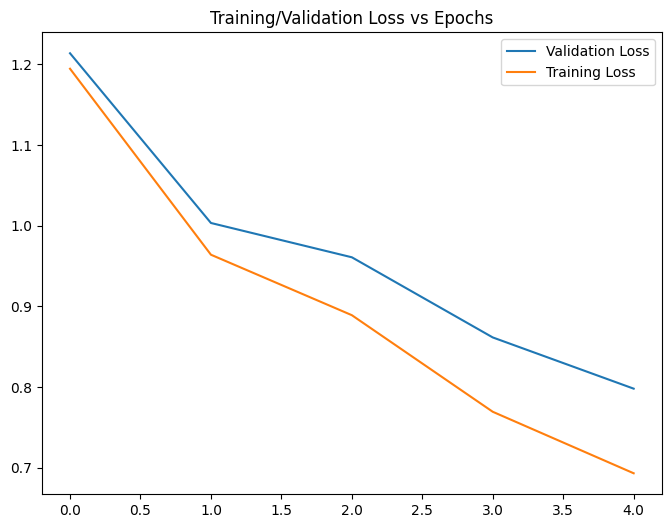

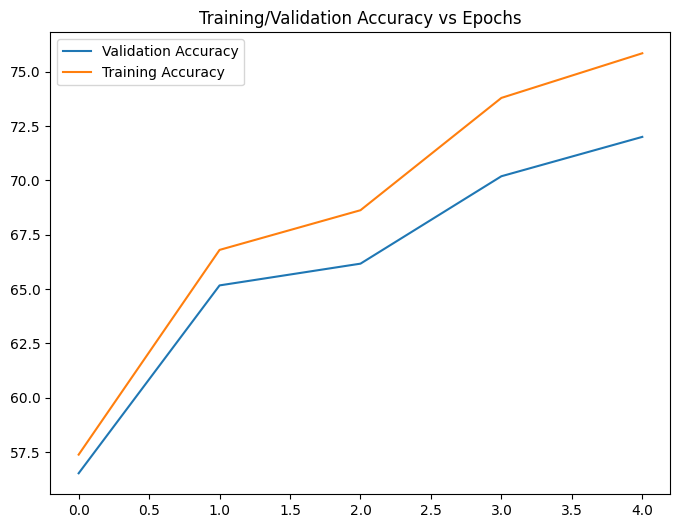

In [ ]:
# creating an instance
third_exp_model = Basic_CNN3()

# moving the model to the default device
thrid_exp_model = third_exp_model.to(device)

# Train the model with specified hyperparameters
third_exp_model.model_train_fn(num_epochs=5, learn_rate=0.01, opt_function="SGD", moment=0.9)

# Show the training and validation loss/accuracy graph
third_exp_model.plot_loss_accuracy_graph()

In [ ]:
third_exp_model.calculate_class_accuracy()

Accuracy of plane : 74.138%
Accuracy of car   : 84.426%
Accuracy of bird  : 51.908%
Accuracy of cat   : 37.097%
Accuracy of deer  : 68.333%
Accuracy of dog   : 67.5%
Accuracy of frog  : 86.777%
Accuracy of horse : 76.692%
Accuracy of ship  : 83.065%
Accuracy of truck : 87.234%


### Experiment 5: Creating model 4 with a combination of batch normalization, smaller convolutional filters, strided convolutions, Leaky ReLu activation

In [ ]:
class Basic_CNN4(BaseNeural):
    def __init__(self, dataset="CIFAR10", batch_size=32, data_path='./data', validation_split=0.2):
        super().__init__()
        torch.manual_seed(42)    # using seed for reproducibility

        # adding first Convolutional Layer with smaller filters and stride
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # adding second Convolutional Layer with smaller filters and stride
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # adding fully connected layer with fewer nodes
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

        # using Leaky ReLU activation
        self.act = nn.LeakyReLU(0.1)

        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        # initilizing a few variables to store results
        self.default_criterioncriterion = None
        self.optimizer = None

        # intializing a summary list to store the results
        self.summary = []
        # intializing number of epochs to zero
        self.epoch = 0

        # making a train, validation, test split on the dataset
        '''
        Since the datset I am working here with is the CIFAR 10 dataset,
        so making the splits only if the passed dataset is the CIFAR 10 dataset.
        '''
        if dataset == "CIFAR10":
            # using in-built torch functions to load the dataset
            dataset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)

            # using 20 percent of the data as the validation set
            validation_size = int(len(dataset) * validation_split)

            # eveything except validation will be used to train the dataset
            training_size = len(dataset) - validation_size
            training_set, validation_set = data.random_split(dataset, [training_size, validation_size])
            self.train_set = training_set
            self.trainloader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=2)
            print("Training Size:", len(training_set))

            self.valloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=2)
            print("Validation Size:", len(validation_set))

            testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
            print("Testing Size:", len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.act(x)

        x = self.fc2(x)
        return x

# Create an instance of Bsic_CNN4 model
model = Basic_CNN4().to(device)
summary(model, (3, 32, 32))


Files already downloaded and verified
Training Size: 40000
Validation Size: 10000
Files already downloaded and verified
Testing Size: 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
       BatchNorm2d-2           [-1, 32, 16, 16]              64
         LeakyReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
       BatchNorm2d-5             [-1, 64, 8, 8]             128
         LeakyReLU-6             [-1, 64, 8, 8]               0
            Linear-7                  [-1, 128]         524,416
         LeakyReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 545,290
Trainable params: 545,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0

### Creating an instance of Basic_CNN4 to check its performance

Files already downloaded and verified
Training Size: 40000
Validation Size: 10000
Files already downloaded and verified
Testing Size: 10000
{'epoch': 1, 'Training_Loss': 1.1073600035190583, 'Training_Accuracy': 60.525, 'Validation_Accuracy': 57.66, 'Validation_Loss': 1.1818420264286735}
{'epoch': 2, 'Training_Loss': 0.8408564415693283, 'Training_Accuracy': 70.045, 'Validation_Accuracy': 62.91, 'Validation_Loss': 1.0324132002580662}
{'epoch': 3, 'Training_Loss': 0.6579204662203789, 'Training_Accuracy': 77.1975, 'Validation_Accuracy': 66.23, 'Validation_Loss': 0.9765324733508661}
{'epoch': 4, 'Training_Loss': 0.5124063940644265, 'Training_Accuracy': 83.0125, 'Validation_Accuracy': 66.44, 'Validation_Loss': 0.9628803333916223}
{'epoch': 5, 'Training_Loss': 0.4087599725484848, 'Training_Accuracy': 86.29, 'Validation_Accuracy': 66.96, 'Validation_Loss': 1.0206945707051518}
Training ended for this run!
Execution time: 14.24 minutes


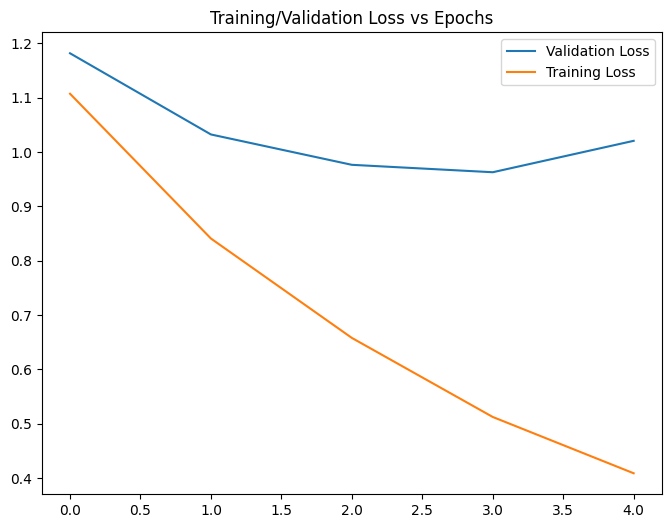

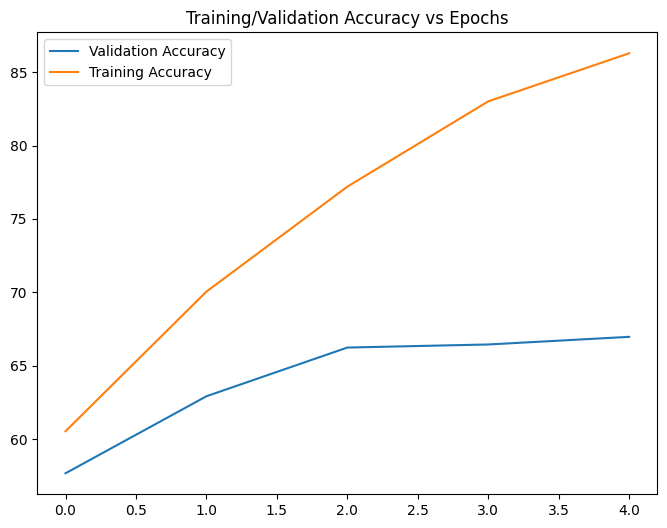

In [ ]:
# creating an instance
fourth_exp_model = Basic_CNN4()

# moving the model to the default device
fourth_exp_model = fourth_exp_model.to(device)

# Train the model with specified hyperparameters
fourth_exp_model.model_train_fn(num_epochs=5, learn_rate=0.01, opt_function="SGD", moment=0.9)

# Show the training and validation loss/accuracy graph
fourth_exp_model.plot_loss_accuracy_graph()

In [ ]:
fourth_exp_model.calculate_class_accuracy()

Accuracy of plane : 80.702%
Accuracy of car   : 77.564%
Accuracy of bird  : 48.0%
Accuracy of cat   : 40.179%
Accuracy of deer  : 52.5%
Accuracy of dog   : 55.385%
Accuracy of frog  : 85.088%
Accuracy of horse : 70.149%
Accuracy of ship  : 82.653%
Accuracy of truck : 76.51%


### Experiment 6: Transfer Learning: ResNet-18 model

In [ ]:
from torchvision import models
from torchvision.models import ResNet18_Weights

class ResNet18_Model(BaseNeural):
    def __init__(self, dataset="CIFAR10", batch_size=16, data_path='./data', validation_split=0.2):
        super().__init__()
        torch.manual_seed(42)  # Using seed for reproducibility

        # Initialize ResNet-18
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 10)  # CIFAR10 has 10 classes, so changing the last layer accordingly

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        # initilizing a few variables to store results
        self.default_criterioncriterion = None
        self.optimizer = None

        # intializing a summary list to store the results
        self.summary = []
        # intializing number of epochs to zero
        self.epoch = 0


        # making a train, validation, test split on the dataset
        '''
        Since the datset I am working here with is the CIFAR 10 dataset,
        so making the splits only if the passed dataset is the CIFAR 10 dataset.
        '''
        if dataset == "CIFAR10":
            # using in-built torch functions to load the dataset
            dataset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)

            # using 20 percent of the data as the validation set
            validation_size = int(len(dataset) * validation_split)

            # eveything except validation will be used to train the dataset
            training_size = len(dataset) - validation_size
            training_set, validation_set = data.random_split(dataset, [training_size, validation_size])
            self.train_set = training_set
            self.trainloader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=2)
            print("Training Size:", len(training_set))

            self.valloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=2)
            print("Validation Size:", len(validation_set))

            testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
            print("Testing Size:", len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


    def forward(self, x):
        return self.model(x)

# Create an instance of ResNet18_Model
model = ResNet18_Model().to(device)
summary(model, (3, 32, 32))


/Users/ramanpreetkaur/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanpreetkaur/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/ramanpreetkaur/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:07<00:00, 6.20MB/s]


Files already downloaded and verified
Training Size: 40000
Validation Size: 10000
Files already downloaded and verified
Testing Size: 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12       

### Creating an instance of the ResNet model and checking its performance

/Users/ramanpreetkaur/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanpreetkaur/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Training Size: 40000
Validation Size: 10000
Files already downloaded and verified
Testing Size: 10000
{'epoch': 1, 'Training_Loss': 0.7423713015913963, 'Training_Accuracy': 73.3075, 'Validation_Accuracy': 70.29, 'Validation_Loss': 0.8368143310546875}
{'epoch': 2, 'Training_Loss': 0.6703565884798766, 'Training_Accuracy': 78.665, 'Validation_Accuracy': 73.93, 'Validation_Loss': 0.7999045709609985}
{'epoch': 3, 'Training_Loss': 0.45441218174844983, 'Training_Accuracy': 86.2025, 'Validation_Accuracy': 79.11, 'Validation_Loss': 0.6436493431568145}
{'epoch': 4, 'Training_Loss': 0.4951601802289486, 'Training_Accuracy': 84.36, 'Validation_Accuracy': 76.3, 'Validation_Loss': 0.7083417044878006}
{'epoch': 5, 'Training_Loss': 0.3356362314850092, 'Training_Accuracy': 89.1625, 'Validation_Accuracy': 79.0, 'Validation_Loss': 0.6159771875917911}
Training ended for this run!
Execution time: 60.2 minutes


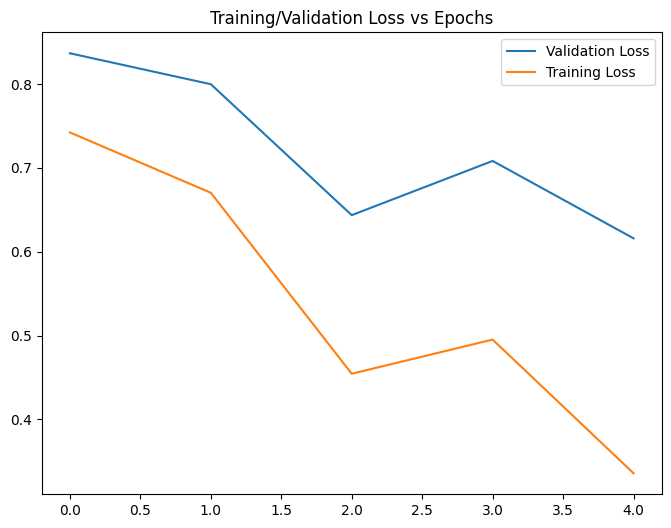

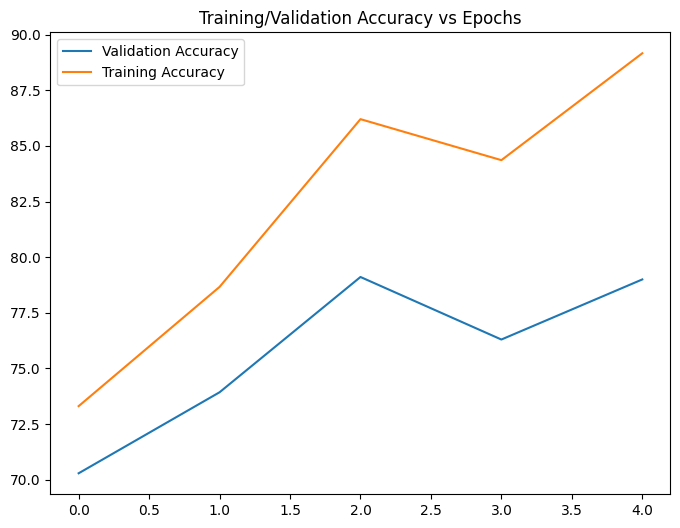

In [ ]:
# creating an instance
resnet_model = ResNet18_Model()

# moving the model to the default device
resnet_model = resnet_model.to(device)

# Train the model with specified hyperparameters
resnet_model.model_train_fn(num_epochs=5, learn_rate=0.01, opt_function="SGD")

# Show the training and validation loss/accuracy graph
resnet_model.plot_loss_accuracy_graph()

In [ ]:
resnet_model.calculate_class_accuracy("val")

Accuracy of plane : 85.185%
Accuracy of car   : 91.111%
Accuracy of bird  : 76.955%
Accuracy of cat   : 60.0%
Accuracy of deer  : 81.028%
Accuracy of dog   : 60.714%
Accuracy of frog  : 91.235%
Accuracy of horse : 81.467%
Accuracy of ship  : 78.838%
Accuracy of truck : 84.698%


In [ ]:
print("Testing first ResNet model on the test set:")
ta, tl = resnet_model.calculate_accuracy_and_loss(resnet_model.testloader, flag = "test")
print("Test accuracy of first resnet model: ", ta)
print("Test loss of the resnet model: ", tl)
resnet_model.calculate_class_accuracy("test")

Testing first ResNet model on the test set:
Test accuracy of first resnet model:  78.64
Test loss of the resnet model:  0.6311765819430352
Accuracy of plane : 86.344%
Accuracy of car   : 94.332%
Accuracy of bird  : 75.18%
Accuracy of cat   : 54.694%
Accuracy of deer  : 82.963%
Accuracy of dog   : 61.25%
Accuracy of frog  : 94.737%
Accuracy of horse : 80.233%
Accuracy of ship  : 83.401%
Accuracy of truck : 82.308%


### Creating another instance of the resnet model with different hyperparmeters

/Users/ramanpreetkaur/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanpreetkaur/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Training Size: 40000
Validation Size: 10000
Files already downloaded and verified
Testing Size: 10000
{'epoch': 1, 'Training_Loss': 0.80717189168334, 'Training_Accuracy': 72.1025, 'Validation_Accuracy': 69.24, 'Validation_Loss': 0.8980503730773925}
{'epoch': 2, 'Training_Loss': 0.6393400419235229, 'Training_Accuracy': 78.49, 'Validation_Accuracy': 73.53, 'Validation_Loss': 0.7756056243419647}
{'epoch': 3, 'Training_Loss': 0.5138999078512192, 'Training_Accuracy': 83.045, 'Validation_Accuracy': 76.42, 'Validation_Loss': 0.6932700062036514}
{'epoch': 4, 'Training_Loss': 0.4302502888679504, 'Training_Accuracy': 85.81, 'Validation_Accuracy': 78.69, 'Validation_Loss': 0.6477536717295647}
{'epoch': 5, 'Training_Loss': 0.3647267973303795, 'Training_Accuracy': 88.43, 'Validation_Accuracy': 78.75, 'Validation_Loss': 0.6274892018675804}
Training ended for this run!
Execution time: 61.46 minutes


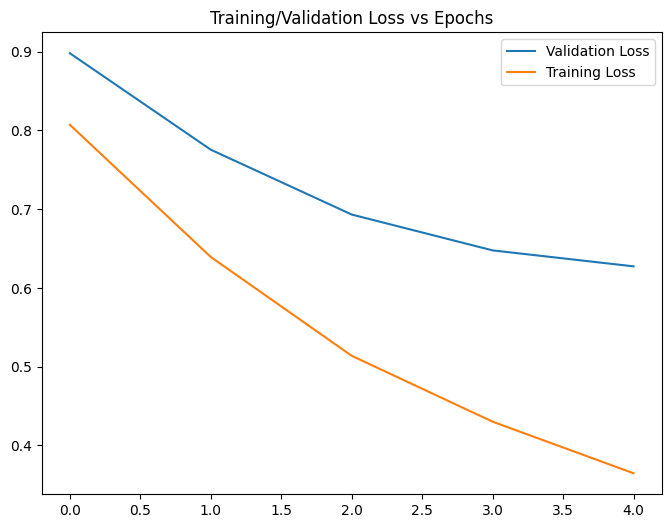

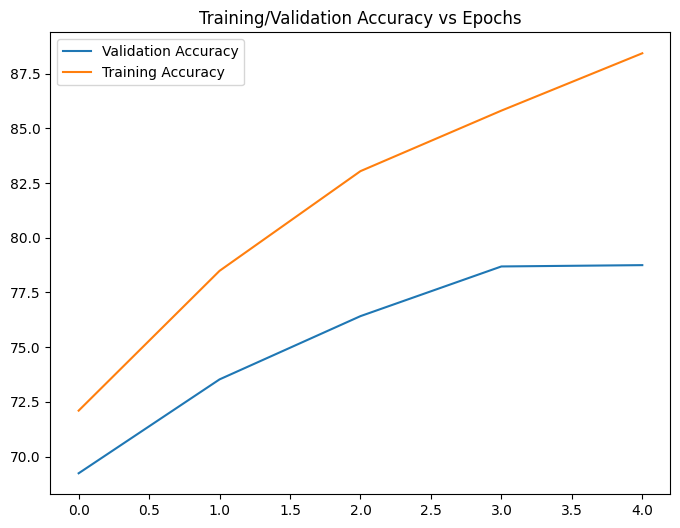

In [ ]:
# creating an instance
resnet_model2 = ResNet18_Model()

# moving the model to the default device
resnet_model2 = resnet_model2.to(device)

# Train the model with specified hyperparameters
resnet_model2.model_train_fn(num_epochs=5, learn_rate=0.001, opt_function="SGD")

# Show the training and validation loss/accuracy graph
resnet_model2.plot_loss_accuracy_graph()

In [ ]:
resnet_model2.calculate_class_accuracy("val")

Accuracy of plane : 83.539%
Accuracy of car   : 90.37%
Accuracy of bird  : 69.547%
Accuracy of cat   : 57.447%
Accuracy of deer  : 81.028%
Accuracy of dog   : 61.607%
Accuracy of frog  : 83.665%
Accuracy of horse : 84.17%
Accuracy of ship  : 84.232%
Accuracy of truck : 85.409%


In [ ]:
print("Testing second ResNet model on the test set:")
ta2, tl2 = resnet_model2.calculate_accuracy_and_loss(resnet_model2.testloader, flag = "test")
print("Test accuracy of second resnet model: ", ta2)
print("Test loss of the second resnet model: ", tl2)
resnet_model2.calculate_class_accuracy("test")

Testing second ResNet model on the test set:
Test accuracy of second resnet model:  79.03
Test loss of the second resnet model:  0.6235897705197334
Accuracy of plane : 85.022%
Accuracy of car   : 91.498%
Accuracy of bird  : 66.187%
Accuracy of cat   : 60.0%
Accuracy of deer  : 77.407%
Accuracy of dog   : 66.25%
Accuracy of frog  : 88.158%
Accuracy of horse : 84.884%
Accuracy of ship  : 85.425%
Accuracy of truck : 87.692%


### Experiment 7: Transfer Learning: VGG-16 model

In [6]:
from torchvision import models
from torchvision.models import VGG16_Weights


class VGG_16(BaseNeural):
    def __init__(self, dataset="CIFAR10", batch_size=15, data_path='./data', validation_split=0.2):
        super().__init__()
        torch.manual_seed(42)  # Using seed for reproducibility
        self.network = models.vgg16(pretrained=True)


        # initilizing a few variables to store results
        self.default_criterioncriterion = None
        self.optimizer = None

        # intializing a summary list to store the results
        self.summary = []
        # intializing number of epochs to zero
        self.epoch = 0


        # making a train, validation, test split on the dataset
        '''
        Since the datset I am working here with is the CIFAR 10 dataset,
        so making the splits only if the passed dataset is the CIFAR 10 dataset.
        '''

        if dataset== "CIFAR10":
            # using in-built torch functions to load the dataset
            dataset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=VGG16_Weights.DEFAULT.transforms())

            # using 20 percent of the data as the validation set
            validation_size = int(len(dataset) * validation_split)

            # eveything except validation will be used to train the dataset
            training_size = len(dataset) - validation_size
            training_set, validation_set = data.random_split(dataset, [training_size, validation_size])
            self.train_set = training_set
            self.trainloader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=2)
            print("Training Size:", len(training_set))

            self.valloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=2)
            print("Validation Size:", len(validation_set))

            testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
            print("Testing Size:", len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


    def forward(self,x):
      return self.network(x)
model = VGG_16().to(device)
summary(model, (3, 32, 32))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 69.5MB/s]


Files already downloaded and verified
Training Size: 40000
Validation Size: 10000
Files already downloaded and verified
Testing Size: 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12       

### Creating an instance of the VGG-16 model and checking its performance

Files already downloaded and verified
Training Size: 40000
Validation Size: 10000
Files already downloaded and verified
Testing Size: 10000
{'epoch': 1, 'Training_Loss': 0.34878786566538406, 'Training_Accuracy': 87.975, 'Validation_Accuracy': 85.89, 'Validation_Loss': 0.4095290492845886}
{'epoch': 2, 'Training_Loss': 0.23390376876500502, 'Training_Accuracy': 92.155, 'Validation_Accuracy': 88.53, 'Validation_Loss': 0.33305348435101256}
{'epoch': 3, 'Training_Loss': 0.13713501250918886, 'Training_Accuracy': 95.53, 'Validation_Accuracy': 90.64, 'Validation_Loss': 0.2788548167198729}
{'epoch': 4, 'Training_Loss': 0.09755816994382283, 'Training_Accuracy': 96.895, 'Validation_Accuracy': 91.08, 'Validation_Loss': 0.2728444460728464}
{'epoch': 5, 'Training_Loss': 0.08344706484644956, 'Training_Accuracy': 97.2525, 'Validation_Accuracy': 90.86, 'Validation_Loss': 0.3023606980195223}
Training ended for this run!
Execution time: 74.38 minutes


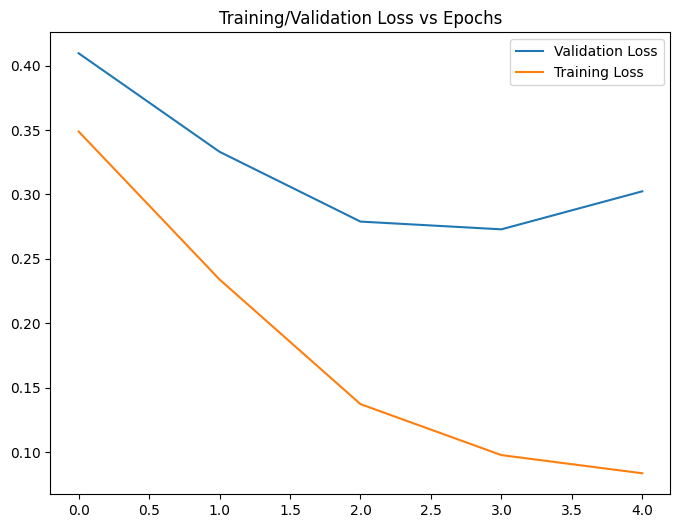

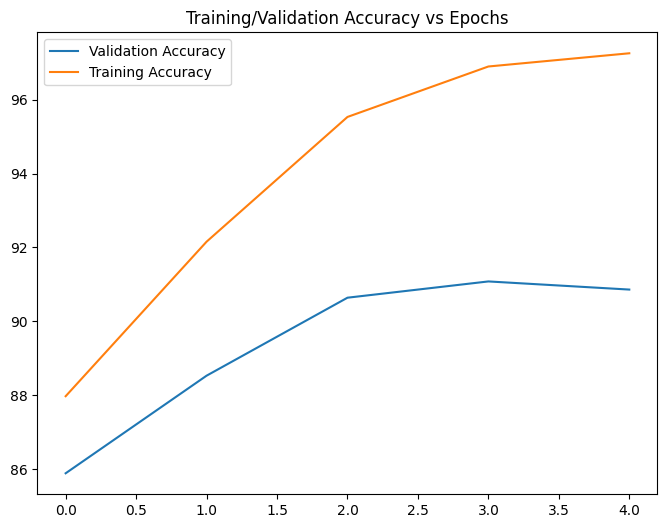

In [7]:
# creating an instance
vgg1 = VGG_16()
vgg1.fc = nn.Linear(512, 10)
# moving the model to the default device
vgg1 = vgg1.to(device)

# Train the model with specified hyperparameters
vgg1.model_train_fn(num_epochs=5, learn_rate=0.001, opt_function="SGD")

# Show the training and validation loss/accuracy graph
vgg1.plot_loss_accuracy_graph()

In [8]:
vgg1.calculate_class_accuracy("val")

Accuracy of plane : 95.76%
Accuracy of car   : 97.586%
Accuracy of bird  : 90.625%
Accuracy of cat   : 86.364%
Accuracy of deer  : 91.288%
Accuracy of dog   : 88.015%
Accuracy of frog  : 95.769%
Accuracy of horse : 85.874%
Accuracy of ship  : 98.182%
Accuracy of truck : 93.893%


### Testing VGG model on the test set

In [10]:
print("Testing VGG model on the test set:")
ta_v, tl_v = vgg1.calculate_accuracy_and_loss(vgg1.testloader, flag = "test")
print("Test accuracy of the VGG model: ", ta_v)
print("Test loss of the VGG model: ", tl_v)
vgg1.calculate_class_accuracy("test")

Testing VGG model on the test set:
Test accuracy of the VGG model:  12.61
Test loss of the VGG model:  7.150904112491293
Accuracy of plane : 13.818%
Accuracy of car   : 0.749%
Accuracy of bird  : 5.66%
Accuracy of cat   : 3.226%
Accuracy of deer  : 24.354%
Accuracy of dog   : 1.562%
Accuracy of frog  : 70.588%
Accuracy of horse : 0.362%
Accuracy of ship  : 11.808%
Accuracy of truck : 0.0%
